In [1]:
#importing required python libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Activation, RepeatVector
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
# loading and  displaying dataset
dataset = pd.read_csv('Dataset/Darknet.csv')
dataset = dataset.drop(columns=['Flow ID', 'Src IP', 'Dst IP', 'Timestamp'])
dataset

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Traffic Type,Traffic Category
0,57158,443,6,229,1,1,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
1,57159,443,6,407,1,1,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
2,57160,443,6,431,1,1,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
3,49134,443,6,359,1,1,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,Audio-Streaming
4,34697,19305,6,10778451,591,400,64530,6659,131,0,...,0,0,0,0,1.440000e+15,3.117718e+06,1.440000e+15,1.440000e+15,Non-Tor,Audio-Streaming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141525,55219,5355,17,411806,2,0,44,0,22,22,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
141526,64207,5355,17,411574,2,0,44,0,22,22,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
141527,61115,5355,17,422299,2,0,44,0,22,22,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP
141528,64790,5355,17,411855,2,0,44,0,22,22,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,VPN,VOIP


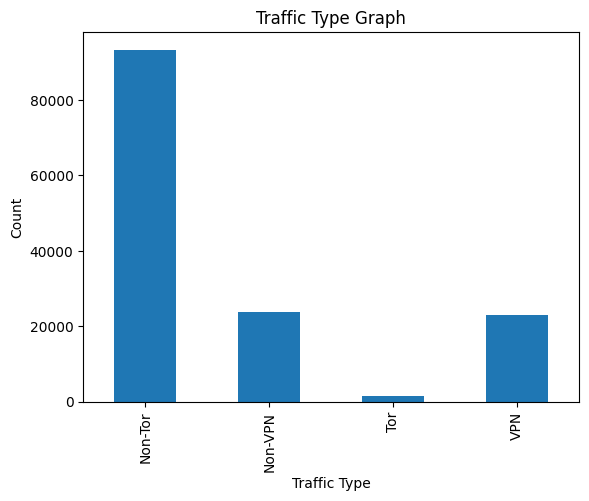

In [3]:
# plotting graph with differnet traffic types found in dataset
traffic_type, traffic_count = np.unique(dataset['Traffic Type'], return_counts=True)
label = dataset.groupby('Traffic Type').size()
label.plot(kind="bar")
plt.xlabel("Traffic Type")
plt.ylabel("Count")
plt.title("Traffic Type Graph")
plt.show()


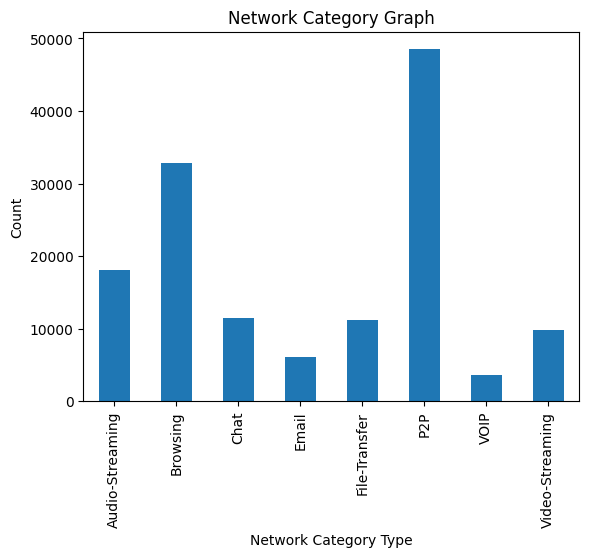

In [4]:
# plotting graph with differnet network categories found in dataset
category_type, category_count = np.unique(dataset['Traffic Category'], return_counts=True)
label = dataset.groupby('Traffic Category').size()
label.plot(kind="bar")
plt.xlabel("Network Category Type")
plt.ylabel("Count")
plt.title("Network Category Graph")
plt.show()

In [5]:
# replacing categorical values with numerical values using Label Encoding

# handling inf values
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.fillna(0, inplace = True) # hanling nan values
dataset = dataset.dropna()
label_encoder = []
columns = dataset.columns
types = dataset.dtypes.values
for i in range(len(types)):
    name = types[i]
    if name == 'object': #finding column with object type
        le = LabelEncoder()
        dataset[columns[i]] = pd.Series(le.fit_transform(dataset[columns[i]].astype(str))) #encode all str columns to numeric 
        label_encoder.append(le)
dataset        

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Traffic Type,Traffic Category
0,57158,443,6,229,1,1,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0
1,57159,443,6,407,1,1,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0
2,57160,443,6,431,1,1,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0
3,49134,443,6,359,1,1,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0
4,34697,19305,6,10778451,591,400,64530,6659,131,0,...,0,0,0,0,1.440000e+15,3.117718e+06,1.440000e+15,1.440000e+15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141525,55219,5355,17,411806,2,0,44,0,22,22,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,6
141526,64207,5355,17,411574,2,0,44,0,22,22,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,6
141527,61115,5355,17,422299,2,0,44,0,22,22,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,6
141528,64790,5355,17,411855,2,0,44,0,22,22,...,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,6


In [6]:
# data preprocessing steps
X = dataset.drop(['Traffic Type','Traffic Category'], axis=1)
Y1 = dataset['Traffic Type']
Y2 = dataset['Traffic Category']
# X = data[:,0:data.shape[1]-2] #extracting X --> data packet information
# Y1 = data[:,data.shape[1]-2] # extracting first target class
# Y2 = data[:,data.shape[1]-1] # extracting second target class

Y1 = Y1.astype(int)
Y2 = Y2.astype(int)

# indices = np.arange(X.shape[0])
# np.random.shuffle(indices) #shuffling the dataset
# X = X[indices]
# Y1 = Y1[indices]
# Y2 = Y2[indices]

# #reshape dataset as 3 dimenssion
# #X = np.reshape(X, (X.shape[0], X.shape[1], 1))
# Y1 = to_categorical(Y1)
# Y2 = to_categorical(Y2)

# splitting dataset into train and test data {4:1}
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y2, test_size=0.2, random_state=42) 




xgb = XGBClassifier()

# Instantiate Standard Scaler
scaler = StandardScaler()
X_train1_scaled = scaler.fit_transform(X_train1)
X_train2_scaled = scaler.fit_transform(X_train2)


xgb.fit(X_train1_scaled, y_train1)

selector = SelectFromModel(xgb, max_features=20, threshold=0.01)

selector.fit(X_train1_scaled, y_train1)
selectedFeat1 = X_train1.columns[selector.get_support()]
X_train1 = X_train1[selectedFeat1]

xgb2 = XGBClassifier()
xgb2.fit(X_train2_scaled, y_train2)
selector2 = SelectFromModel(xgb2, max_features=20, threshold=0.01)

selector2.fit(X_train2_scaled, y_train2)
selectedFeat2 = X_train2.columns[selector2.get_support()]
X_train2 = X_train2[selectedFeat2]
selectedFeat2

print()
print("Total records found in dataset : "+str(X.shape[0]))
print("Training Size (80%): "+str(X_train1.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test1.shape[0]))
print()



Total records found in dataset : 141530
Training Size (80%): 113224
Testing Size (20%): 28306



In [7]:
# function to calculate performance analysis of the model
def calculateMetrics(algorithm, model, predict, testY):
    testY = testY.astype('int')
    predict = predict.astype('int')

    # performance metrics
    p = precision_score(testY, predict, average='macro') * 100
    r = recall_score(testY, predict, average='macro') * 100
    f = f1_score(testY, predict, average='macro') * 100
    a = accuracy_score(testY, predict)*100 
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FSCORE      : '+str(f))

    # confusion matrix to visualize the relativity b/w test class & predicted class
    conf_matrix = confusion_matrix(testY, predict) 
     
    
    if model == 1:
        plt.figure(figsize =(5, 5))
        ax = sns.heatmap(conf_matrix, xticklabels = traffic_type, yticklabels = traffic_type, annot = True, cmap="viridis" ,fmt ="g");
        ax.set_ylim([0,len(traffic_type)])
        plt.title(algorithm+" Confusion matrix") 
        plt.ylabel('True class') 
        plt.xlabel('Predicted class') 
    else:
        plt.figure(figsize =(10, 7))
        ax = sns.heatmap(conf_matrix, xticklabels = category_type, yticklabels = category_type, annot = True, cmap="viridis" ,fmt ="g");
        ax.set_ylim([0,len(category_type)])
        plt.title(algorithm+" Confusion matrix") 
        plt.ylabel('True class') 
        plt.xlabel('Predicted class') 
    # plt.tight_layout()
    plt.show()
X_train1

,Fwd Packet Length Min,Bwd Packet Length Min,Flow IAT Mean,Flow IAT Std,Fwd Header Length,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Std,Subflow Fwd Bytes,FWD Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Max
83624,0,0,4.738642e+04,1.325036e+05,212,11.106890,0,208,61.664067,26,14600,6,20,1.460000e+15,1.460000e+15
106570,22,0,4.221190e+05,0.000000e+00,16,0.000000,22,22,0.000000,22,0,1,8,0.000000e+00,0.000000e+00
13844,0,0,2.018967e+04,1.096777e+05,472,25.315480,0,1460,652.695545,7,14600,1,20,1.460000e+15,1.460000e+15
80019,20,0,4.889594e+06,1.994426e+06,24,0.000000,20,20,0.000000,20,0,2,8,1.460000e+15,1.460000e+15
33331,0,0,2.143437e+04,4.895904e+05,39580,16.467029,0,1460,670.894145,805,10510,1948,20,1.440000e+15,1.440000e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,22,0,4.117740e+05,0.000000e+00,16,0.000000,22,22,0.000000,22,0,1,8,0.000000e+00,0.000000e+00
119879,144,52,8.094300e+04,0.000000e+00,8,12.354373,52,144,53.116225,72,0,0,8,0.000000e+00,0.000000e+00
103694,37,213,3.670000e+02,0.000000e+00,8,2724.795640,37,213,101.613647,18,0,0,8,0.000000e+00,0.000000e+00
131932,33,345,7.830000e+02,0.000000e+00,8,1277.139208,33,345,180.133284,16,0,0,8,0.000000e+00,0.000000e+00


In [8]:
# AutoEncoder model architecture definition for predicting first target class

# encoder part of model is created using cnn
auto_enc_dec = Sequential()
# cnn layer with 32 neurons or filters to filter and encode dataset features
auto_enc_dec.add(Conv1D(filters=32, kernel_size=9, activation='relu', input_shape=(X_train1.shape[1])))
# another layer with 16 neurons to further filter features
auto_enc_dec.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
# max pool layer to collect filtered features from CNN
auto_enc_dec.add(MaxPooling1D(pool_size=2))

#convert multidimension features to single dimension
auto_enc_dec.add(Flatten())
auto_enc_dec.add(RepeatVector(2))

# decoder part of model is created using lstm
auto_enc_dec.add(LSTM(16, activation='relu'))
# defining output layer with 100 neurons
auto_enc_dec.add(Dense(units = 8, activation = 'relu'))
auto_enc_dec.add(Dense(units = 4, activation = 'softmax'))

#compile the model
auto_enc_dec.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# train and load the model
# it also saves the updated weights of network in hdf5 format
if os.path.exists("model/encoder_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/encoder_weights.hdf5', verbose = 1, save_best_only = True)
    hist = auto_enc_dec.fit(X_train1, y_train1, batch_size = 256, epochs = 5, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
else:
    auto_enc_dec.load_weights("model/encoder_weights.hdf5")
# category_model = load_model("model/encoder_category_weights.hdf5")    
predict = auto_enc_dec.predict(X_test1)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test1, axis=1)
calculateMetrics("AutoEncoder", 1, predict, testY)


TypeError: 'int' object is not iterable

In [9]:
# AutoEncoder model architecture definition for predicting second target class

# encoder part of model is created using cnn
auto_enc_dec2 = Sequential()
# cnn layer with 32 neurons or filters to filter and encode dataset features
auto_enc_dec2.add(Conv1D(filters=32, kernel_size=9, activation='relu', input_shape=(X_train2.shape[1], X_train2.shape[2])))
# another layer with 16 neurons to further filter features
auto_enc_dec2.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
# max pool layer to collect filtered features from CNN
auto_enc_dec2.add(MaxPooling1D(pool_size=2))

#convert multidimension features to single dimension
auto_enc_dec2.add(Flatten())
auto_enc_dec2.add(RepeatVector(2))

# decoder part of model is created using lstm
auto_enc_dec2.add(LSTM(32, activation='relu'))
# defining output layer with 100 neurons
auto_enc_dec2.add(Dense(units = 100, activation = 'relu'))
auto_enc_dec2.add(Dense(units = 8, activation = 'softmax'))

#compile the model
auto_enc_dec2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# train and load the model
# it also saves the updated weights of network in hdf5 format
if os.path.exists("model/encoder_category_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/encoder_category_weights.hdf5', verbose = 1, save_best_only = True)
    hist = auto_enc_dec2.fit(X_train2, y_train2, batch_size = 256, epochs = 10, validation_data=(X_test2, y_test2), callbacks=[model_check_point], verbose=1)
else:
    auto_enc_dec2.load_weights("model/encoder_category_weights.hdf5")
# category_model = load_model("model/encoder_category_weights.hdf5")    
predict = auto_enc_dec2.predict(X_test2)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test2, axis=1)
calculateMetrics("AutoEncoder", 2, predict, testY)


IndexError: tuple index out of range

In [10]:

dataset = pd.read_csv('Dataset/testData.csv')  # loading test data
dataset.fillna(0, inplace=True)  # removing missing values
dataset = dataset.sample(frac = 1)
index = 0
columns = dataset.columns
types = dataset.dtypes.values
label_encoder = []  # initializing an empty list of label encoders
for i in range(len(types)):
    name = types[i]
    if name == 'object':
        if len(label_encoder) <= index:  # checking if the label encoder list needs to be extended
            label_encoder.append(LabelEncoder())
        dataset[columns[i]] = pd.Series(label_encoder[index].fit_transform(dataset[columns[i]].astype(str)))
        index = index + 1

dataset = dataset.values
X = scaler.transform(dataset)  # normalizing values
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
traffic_type_predict = auto_enc_dec.predict(X)  # performing prediction on test data
network_category = auto_enc_dec2.predict(X)
for i in range(len(X)):
    print("Traffic Test Data : " + str(dataset[i]))
    print("Predicted Traffic Type : " + traffic_type[int(np.argmax(traffic_type_predict[i]))])
    print("Predicted Network Category : " + category_type[int(np.argmax(network_category[i]))])
    print()



C:\Users\mukes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 83 features, but StandardScaler is expecting 79 features as input.